### Custom Returns Check

In [53]:
### 라이브러리
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import datetime

### 환경설정
np.random.seed(4)

def trim_date(df, start, end):
    ### df date 형식 맞춰주기
    df['date'] = df['date'].astype(str)
    if len(df['date'][0]) == 8:
        df['date'] = df['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])


    return df[(df['date']>=start) & (df['date']<=end)]

In [54]:
### 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")
test_df.set_index('date', inplace=True)

### target df 읽기
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_33_threshold_1000_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_receive.csv")
# target_event_receive_df = pd.read_csv("./data/target/screened_event_2_day_transactions_over_25_threshold_1000_receive.csv")
target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_136_threshold_1000_receive.csv")
target_event_receive_df.columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']
target_event_receive_df = trim_date(target_event_receive_df, (test_df.index)[0], (test_df.index)[-1])



### Bitcoin Event Flag 추가 / 긍정, 부정, 애매 이벤트 필터링
# pos, neg, neu, all
event_sentiment = 'neg'

event_df = pd.read_csv("./data/event/bitcoin_event_details_sentiment.csv")
event_df.index = event_df['Date'].astype(str).apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:])

if event_sentiment == 'all':
    pass
elif event_sentiment == 'pos':
    event_df = event_df[event_df['classification']==1]
elif event_sentiment == 'neg':
    event_df = event_df[event_df['classification']==0]
elif event_sentiment == 'neu':
    event_df = event_df[event_df['classification']==2]
event_df['classification'] = 1
event_df = event_df['classification']
event_df = event_df[~event_df.index.duplicated(keep='first')]
test_df['event_flag'] = event_df
test_df['event_flag'] = test_df['event_flag'].fillna(0)
event_flag_copy = test_df['event_flag'].values


### 분석 데이터 선택
target_df = target_event_receive_df.copy().set_index('date')

### test_df에 target_df 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

### test_df의 target 선택
test_df['target'] = test_df['transaction_amount_usd']
test_df['target'] = np.where(test_df['target'] == 0, 1e-10, test_df['target'])

### target 관련 파생변수 생성
test_df['target_delta'] = test_df['target'].diff(1)
test_df['target_returns'] = test_df['target'].pct_change(1)

### VPIN 관련 변수 추가
vpin = pd.read_csv('./data/vpin/vpin.csv')
vpin['ma_10'] = vpin['vpin'].rolling(10).mean()
vpin['ma_10'] = vpin['ma_10'].fillna(vpin['ma_10'].mean())
vpin = vpin.set_index('date')
test_df['vpin'] = vpin['vpin']
test_df['vpin_ma_10'] = vpin['ma_10']

### 수익률 관련 변수
returns_copy = test_df['returns'].copy()

##### 전처리 관련
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())


test_df = test_df[test_df.index >= '2018-01-01']

C:\Users\slaye\AppData\Local\Temp\ipykernel_28084\1457745969.py:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


### Custom Testing용 파생변수 생성

In [55]:
# trading flag 생성
test_df['transaction_amount_returns'] = test_df['transaction_amount_usd'].pct_change(1).fillna(test_df.mean())
threshold = 0
test_df['transaction_amount_trading_flag'] = test_df['transaction_amount_returns'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else (-1 if x == np.inf else 0)))
test_df['transaction_amount_trading_reversion'] = test_df['transaction_amount_returns'].apply(lambda x: -1 if x > 0 else (1 if x < -0 else 0))

# 지연 수익률 계산, carrying 수익률 
test_df['returns'] = test_df['close'].pct_change(1).fillna(test_df.mean())
test_df['returns_after_1day'] = test_df['returns'].shift(-2).fillna(test_df.mean())
test_df['returns_after_2day'] = test_df['returns'].shift(-3).fillna(test_df.mean())
test_df['returns_after_3day'] = test_df['returns'].shift(-4).fillna(test_df.mean())
test_df['returns_during_2day'] = test_df['close'].pct_change(2).shift(-2).fillna(test_df.mean())
test_df['returns_during_3day'] = test_df['close'].pct_change(3).shift(-3).fillna(test_df.mean())

## 변화율에서 inf값 나올텐데 그거 어떻게 처리할지
test_df = test_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.fillna(test_df.mean())


# check test df 날짜 인덱싱
check_test_df = test_df.copy()
check_test_df = check_test_df[check_test_df.index>='2018-01-01']

# Trading 결과 확인하기 위해 adjusted_returns 생성
check_test_df['adjusted_returns'] = 0 # 새로운 열 'adjusted_returns'를 생성하여 기본값을 0으로 설정

trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==-1]

# 'adjusted_returns' 열을 float으로 변환 후 값 할당
check_test_df['adjusted_returns'] = check_test_df['adjusted_returns'].astype(float)
check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_2day'].astype(float).copy()

# trading_price_df = check_test_df[check_test_df['transaction_amount_trading_flag']==1]
# check_test_df.loc[trading_price_df.index, 'adjusted_returns'] = trading_price_df['returns_after_1day'].apply(lambda x: -x) # trading_price_df의 index에 해당하는 행만 원래 'returns' 값을 유지

In [56]:
print("The mean of returns:", test_df['returns'].mean())
print("The median of returns:", test_df['returns'].median())
print("The std of returns:", test_df['returns'].std())
print("The max of returns:", test_df['returns'].max())
print("The min of returns:", test_df['returns'].min())
print("The win rate of returns:", test_df['returns'].gt(0).sum() / len(test_df))
print("The count of returns:", test_df['returns'].count())

The mean of returns: 0.0012956489055175552
The median of returns: 0.0007112893552991828
The std of returns: 0.03614064434414157
The max of returns: 0.1953613919484356
The min of returns: -0.3950484717412017
The win rate of returns: 0.5119675456389452
The count of returns: 2465


In [57]:
print("The mean of returns:", test_df['returns_during_2day'].mean())
print("The median of returns:", test_df['returns_during_2day'].median())
print("The std of returns:", test_df['returns_during_2day'].std())
print("The max of returns:", test_df['returns_during_2day'].max())
print("The min of returns:", test_df['returns_during_2day'].min())
print("The win rate of returns:", test_df['returns_during_2day'].gt(0).sum() / len(test_df))
print("The count of returns:", test_df['returns_during_2day'].count())



The mean of returns: 0.0024808157327984265
The median of returns: 0.002051243194094221
The std of returns: 0.04947070534002361
The max of returns: 0.24520904806938626
The min of returns: -0.39198638049492307
The win rate of returns: 0.5310344827586206
The count of returns: 2465


In [58]:
print("The mean of returns:", test_df['returns_during_3day'].mean())
print("The median of returns:", test_df['returns_during_3day'].median())
print("The std of returns:", test_df['returns_during_3day'].std())
print("The max of returns:", test_df['returns_during_3day'].max())
print("The min of returns:", test_df['returns_during_3day'].min())
print("The win rate of returns:", test_df['returns_during_3day'].gt(0).sum() / len(test_df))
print("The count of returns:", test_df['returns_during_3day'].count())

The mean of returns: 0.0037300752912213164
The median of returns: 0.002362998604076516
The std of returns: 0.06102589190327878
The max of returns: 0.28567227123162375
The min of returns: -0.394693733945197
The win rate of returns: 0.5253549695740365
The count of returns: 2465


In [59]:
### 만약 상위 1% threshold를 넘기면?
threshold = test_df.target.quantile(0.90)
returns_check_df = test_df[test_df['target']>=threshold]


print("The mean of Top 3% returns:", returns_check_df['returns_after_1day'].mean())
print("The median of Top 3% returns:", returns_check_df['returns_after_1day'].median())
print("The std of Top 3% returns:", returns_check_df['returns_after_1day'].std())
print("The max of Top 3% returns:", returns_check_df['returns_after_1day'].max())
print("The min of Top 3% returns:", returns_check_df['returns_after_1day'].min())
print("The win rate of Top 3% returns:", returns_check_df['returns_after_1day'].gt(0).sum() / len(returns_check_df))
print("The count of Top 3% returns:", returns_check_df['returns_after_1day'].count())


The mean of Top 3% returns: 0.0004706099126677108
The median of Top 3% returns: -0.00013521805068350545
The std of Top 3% returns: 0.03834120783991184
The max of Top 3% returns: 0.1262223148914241
The min of Top 3% returns: -0.1437507963868193
The win rate of Top 3% returns: 0.48582995951417
The count of Top 3% returns: 247


In [60]:
### 만약 상위 1% threshold를 넘기면?
threshold = test_df.target.quantile(0.90)
returns_check_df = test_df[test_df['target']>=threshold]


print("The mean of Top 3% returns:", returns_check_df['returns_after_2day'].mean())
print("The median of Top 3% returns:", returns_check_df['returns_after_2day'].median())
print("The std of Top 3% returns:", returns_check_df['returns_after_2day'].std())
print("The max of Top 3% returns:", returns_check_df['returns_after_2day'].max())
print("The min of Top 3% returns:", returns_check_df['returns_after_2day'].min())
print("The win rate of Top 3% returns:", returns_check_df['returns_after_2day'].gt(0).sum() / len(returns_check_df))
print("The count of Top 3% returns:", returns_check_df['returns_after_2day'].count())


The mean of Top 3% returns: -0.001993794095284387
The median of Top 3% returns: -0.0015526617078359672
The std of Top 3% returns: 0.039925814658218886
The max of Top 3% returns: 0.1262223148914241
The min of Top 3% returns: -0.15208905276970397
The win rate of Top 3% returns: 0.4534412955465587
The count of Top 3% returns: 247


In [61]:
### 만약 상위 1% threshold를 넘기면?
threshold = test_df.target.quantile(0.90)
returns_check_df = test_df[test_df['target']>=threshold]


print("The mean of Top 3% returns:", returns_check_df['returns_after_3day'].mean())
print("The median of Top 3% returns:", returns_check_df['returns_after_3day'].median())
print("The std of Top 3% returns:", returns_check_df['returns_after_3day'].std())
print("The max of Top 3% returns:", returns_check_df['returns_after_3day'].max())
print("The min of Top 3% returns:", returns_check_df['returns_after_3day'].min())
print("The win rate of Top 3% returns:", returns_check_df['returns_after_3day'].gt(0).sum() / len(returns_check_df))
print("The count of Top 3% returns:", returns_check_df['returns_after_3day'].count())


The mean of Top 3% returns: -0.0018330807429777119
The median of Top 3% returns: -0.00013521805068350545
The std of Top 3% returns: 0.0421594520623797
The max of Top 3% returns: 0.14485582800848928
The min of Top 3% returns: -0.19497368154783667
The win rate of Top 3% returns: 0.4939271255060729
The count of Top 3% returns: 247


In [62]:
### 만약 상위 1% threshold를 넘기면?
threshold = test_df.target.quantile(0.90)
returns_check_df = test_df[test_df['target']>=threshold]


print("The mean of Top 3% returns:", returns_check_df['returns_during_2day'].mean())
print("The median of Top 3% returns:", returns_check_df['returns_during_2day'].median())
print("The std of Top 3% returns:", returns_check_df['returns_during_2day'].std())
print("The max of Top 3% returns:", returns_check_df['returns_during_2day'].max())
print("The min of Top 3% returns:", returns_check_df['returns_during_2day'].min())
print("The win rate of Top 3% returns:", returns_check_df['returns_during_2day'].gt(0).sum() / len(returns_check_df))
print("The count of Top 3% returns:", returns_check_df['returns_during_2day'].count())


The mean of Top 3% returns: 0.0002652388209300307
The median of Top 3% returns: -0.0008826903539871367
The std of Top 3% returns: 0.0534045897573278
The max of Top 3% returns: 0.19653549144247706
The min of Top 3% returns: -0.22671509528617428
The win rate of Top 3% returns: 0.48582995951417
The count of Top 3% returns: 247


In [63]:
### 만약 상위 1% threshold를 넘기면?
threshold = test_df.target.quantile(0.90)
returns_check_df = test_df[test_df['target']>=threshold]


print("The mean of Top 3% returns:", returns_check_df['returns_during_3day'].mean())
print("The median of Top 3% returns:", returns_check_df['returns_during_3day'].median())
print("The std of Top 3% returns:", returns_check_df['returns_during_3day'].std())
print("The max of Top 3% returns:", returns_check_df['returns_during_3day'].max())
print("The min of Top 3% returns:", returns_check_df['returns_during_3day'].min())
print("The win rate of Top 3% returns:", returns_check_df['returns_during_3day'].gt(0).sum() / len(returns_check_df))
print("The count of Top 3% returns:", returns_check_df['returns_during_3day'].count())


The mean of Top 3% returns: -0.0019317386425560686
The median of Top 3% returns: -0.0034135270602313472
The std of Top 3% returns: 0.06324979457130064
The max of Top 3% returns: 0.19538650461434948
The min of Top 3% returns: -0.2178556817682349
The win rate of Top 3% returns: 0.47368421052631576
The count of Top 3% returns: 247


In [64]:
# ### 만약 하위 3% threshold를 넘기면?
# threshold = test_df.target.quantile(0.03)
# returns_check_df = test_df[test_df['target']<=threshold]


# print("The mean of Bottom 3% returns:", returns_check_df['returns_after_1day'].mean())
# print("The median of Bottom 3% returns:", returns_check_df['returns_after_1day'].median())
# print("The std of Bottom 3% returns:", returns_check_df['returns_after_1day'].std())
# print("The max of Bottom 3% returns:", returns_check_df['returns_after_1day'].max())
# print("The min of Bottom 3% returns:", returns_check_df['returns_after_1day'].min())
# print("The win rate of Bottom 3% returns:", returns_check_df['returns_after_1day'].gt(0).sum() / len(returns_check_df))
# print("The count of Bottom 3% returns:", returns_check_df['returns_after_1day'].count())


# print("The mean of Bottom 3% returns:", returns_check_df['returns_after_2day'].mean())
# print("The median of Bottom 3% returns:", returns_check_df['returns_after_2day'].median())
# print("The std of Bottom 3% returns:", returns_check_df['returns_after_2day'].std())
# print("The max of Bottom 3% returns:", returns_check_df['returns_after_2day'].max())
# print("The min of Bottom 3% returns:", returns_check_df['returns_after_2day'].min())
# print("The win rate of Bottom 3% returns:", returns_check_df['returns_after_2day'].gt(0).sum() / len(returns_check_df))
# print("The count of Bottom 3% returns:", returns_check_df['returns_after_2day'].count())


# print("The mean of Bottom 3% returns:", returns_check_df['returns_during_2day'].mean())
# print("The median of Bottom 3% returns:", returns_check_df['returns_during_2day'].median())
# print("The std of Bottom 3% returns:", returns_check_df['returns_during_2day'].std())
# print("The max of Bottom 3% returns:", returns_check_df['returns_during_2day'].max())
# print("The min of Bottom 3% returns:", returns_check_df['returns_during_2day'].min())
# print("The win rate of Bottom 3% returns:", returns_check_df['returns_during_2day'].gt(0).sum() / len(returns_check_df))
# print("The count of Bottom 3% returns:", returns_check_df['returns_during_2day'].count())

# print("The mean of Bottom 3% returns:", returns_check_df['returns_during_3day'].mean())
# print("The median of Bottom 3% returns:", returns_check_df['returns_during_3day'].median())
# print("The std of Bottom 3% returns:", returns_check_df['returns_during_3day'].std())
# print("The max of Bottom 3% returns:", returns_check_df['returns_during_3day'].max())
# print("The min of Bottom 3% returns:", returns_check_df['returns_during_3day'].min())
# print("The win rate of Bottom 3% returns:", returns_check_df['returns_during_3day'].gt(0).sum() / len(returns_check_df))
# print("The count of Bottom 3% returns:", returns_check_df['returns_during_3day'].count())


C:\Users\slaye\AppData\Local\Temp\ipykernel_28084\2641463487.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_check_df['loose'] = np.where(returns_check_df['returns_after_1day'] < 0, 1, 0)
C:\Users\slaye\AppData\Local\Temp\ipykernel_28084\2641463487.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_check_df['high_loose'] = np.where(returns_check_df['returns_after_1day'] < -0.05, 1, 0)  # 5% 이상 수익 거래
C:\Users\slaye\AppData\Local\Temp\ipykernel_28084\2641463487.py:106: SettingWithCopyWa

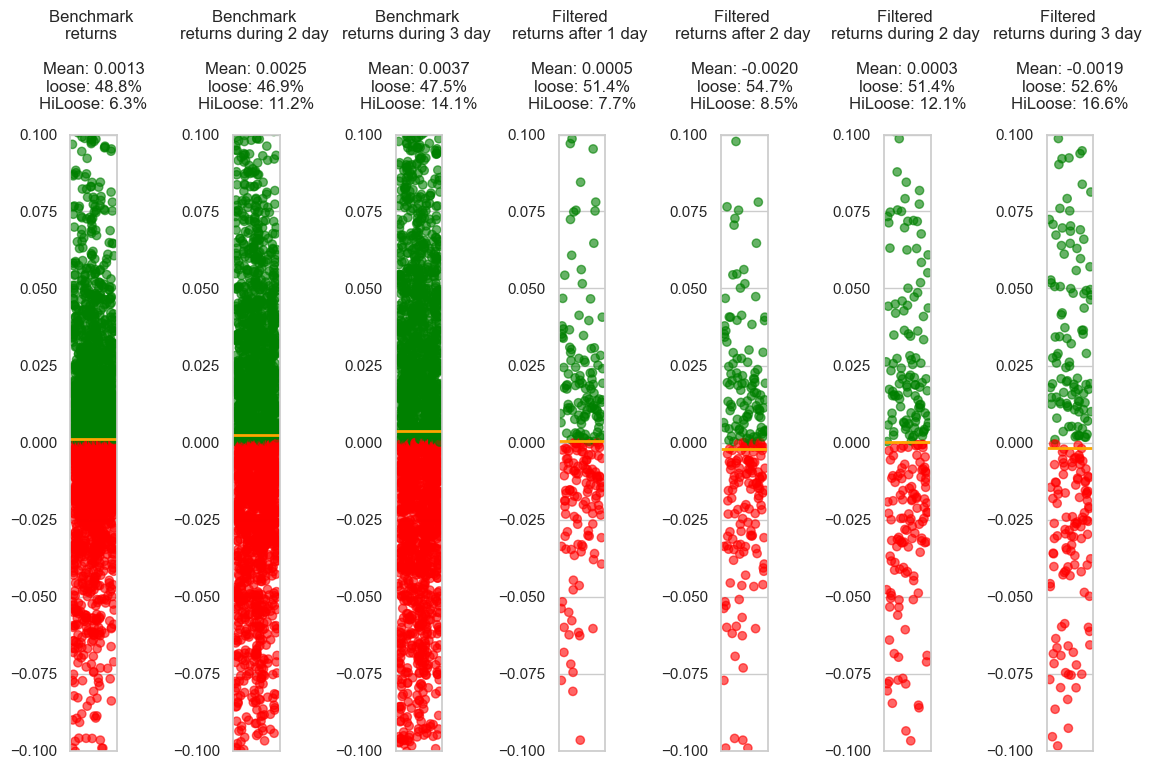

In [65]:
# 시각화
plt.figure(figsize=(30, 8))
sns.set(style='whitegrid')
##################################################


test_df['returns']
test_df['loose'] = np.where(test_df['returns'] < 0, 1, 0)
test_df['high_loose'] = np.where(test_df['returns'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 1)
plt.scatter(range(len(test_df)), test_df['returns'], 
            color=np.where(test_df['returns'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(test_df['returns'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = test_df['returns'].mean()
loose_ratio = (test_df['loose'].mean()) * 100
high_loose_ratio = (test_df['high_loose'].mean()) * 100

plt.title(f"Benchmark \nreturns \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)

#########################################

test_df['returns_during_2day']
test_df['loose'] = np.where(test_df['returns_during_2day'] < 0, 1, 0)
test_df['high_loose'] = np.where(test_df['returns_during_2day'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 2)
plt.scatter(range(len(test_df)), test_df['returns_during_2day'], 
            color=np.where(test_df['returns_during_2day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(test_df['returns_during_2day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = test_df['returns_during_2day'].mean()
loose_ratio = (test_df['loose'].mean()) * 100
high_loose_ratio = (test_df['high_loose'].mean()) * 100

plt.title(f"Benchmark \nreturns during 2 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)

#########################################

test_df['returns_during_3day']
test_df['loose'] = np.where(test_df['returns_during_3day'] < 0, 1, 0)
test_df['high_loose'] = np.where(test_df['returns_during_3day'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 3)
plt.scatter(range(len(test_df)), test_df['returns_during_3day'], 
            color=np.where(test_df['returns_during_3day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(test_df['returns_during_3day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = test_df['returns_during_3day'].mean()
loose_ratio = (test_df['loose'].mean()) * 100
high_loose_ratio = (test_df['high_loose'].mean()) * 100

plt.title(f"Benchmark \nreturns during 3 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)
plt.subplots_adjust(wspace=2.5)


#########################################

returns_check_df['returns_after_1day']
returns_check_df['loose'] = np.where(returns_check_df['returns_after_1day'] < 0, 1, 0)
returns_check_df['high_loose'] = np.where(returns_check_df['returns_after_1day'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 4)
plt.scatter(range(len(returns_check_df)), returns_check_df['returns_after_1day'], 
            color=np.where(returns_check_df['returns_after_1day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(returns_check_df['returns_after_1day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = returns_check_df['returns_after_1day'].mean()
loose_ratio = (returns_check_df['loose'].mean()) * 100
high_loose_ratio = (returns_check_df['high_loose'].mean()) * 100

plt.title(f"Filtered \nreturns after 1 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)

#########################################

returns_check_df['returns_after_2day']
returns_check_df['loose'] = np.where(returns_check_df['returns_after_2day'] < 0, 1, 0)
returns_check_df['high_loose'] = np.where(returns_check_df['returns_after_2day'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 5)
plt.scatter(range(len(returns_check_df)), returns_check_df['returns_after_2day'], 
            color=np.where(returns_check_df['returns_after_2day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(returns_check_df['returns_after_2day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = returns_check_df['returns_after_2day'].mean()
loose_ratio = (returns_check_df['loose'].mean()) * 100
high_loose_ratio = (returns_check_df['high_loose'].mean()) * 100

plt.title(f"Filtered \nreturns after 2 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)


################################ during 2

returns_check_df['returns_during_2day']
returns_check_df['loose'] = np.where(returns_check_df['returns_during_2day'] < 0, 1, 0)
returns_check_df['high_loose'] = np.where(returns_check_df['returns_during_2day'] < -0.05, 1, 0)  # 5% 이상 수익 거래


# 산포도 (3-day return)
plt.subplot(1, 15, 6)
plt.scatter(range(len(returns_check_df)), returns_check_df['returns_during_2day'], 
            color=np.where(returns_check_df['returns_during_2day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(returns_check_df['returns_during_2day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = returns_check_df['returns_during_2day'].mean()
loose_ratio = (returns_check_df['loose'].mean()) * 100
high_loose_ratio = (returns_check_df['high_loose'].mean()) * 100

plt.title(f"Filtered \nreturns during 2 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)


############################################


returns_check_df['returns_during_3day']
returns_check_df['loose'] = np.where(returns_check_df['returns_during_3day'] < 0, 1, 0)
returns_check_df['high_loose'] = np.where(returns_check_df['returns_during_3day'] < -0.05, 1, 0)  # 5% 이상 수익 거래

# 산포도 (3-day return)
plt.subplot(1, 15, 7)
plt.scatter(range(len(returns_check_df)), returns_check_df['returns_during_3day'], 
            color=np.where(returns_check_df['returns_during_3day'] > 0, 'green', 'red'), alpha=0.6)

# 평균선 추가
plt.axhline(returns_check_df['returns_during_3day'].mean(), color='orange', linewidth=2)

# 통계 요약 추가
mean_val = returns_check_df['returns_during_3day'].mean()
loose_ratio = (returns_check_df['loose'].mean()) * 100
high_loose_ratio = (returns_check_df['high_loose'].mean()) * 100

plt.title(f"Filtered \nreturns during 3 day \n\nMean: {mean_val:.4f}\nloose: {loose_ratio:.1f}%\nHiLoose: {high_loose_ratio:.1f}%\n")
plt.xticks([])  # X축 값 제거
plt.ylim(-0.1, 0.1)

#########################################

# 고해상도 저장
plt.savefig('./figure/custom_testing_comparing_returns.pdf', dpi=300, bbox_inches='tight')
plt.show()